In [180]:
%load_ext autoreload
%autoreload 2

import util as yu
from util import *

yu.setpath('check_KyriakosStrategy')

projs=['P0', 'Px', 'Py', 'Pz']
inserts=['tt', 'tx', 'ty', 'tz', 'xx', 'xy', 'xz', 'yy', 'yz', 'zz']
enss=['b','c','d']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
# conn
path='pkl/analysis_avgx/reg_ignore/key2bare_conn.pkl'
key2bare_conn=yu.load_pkl(path)

# for key in key2bare_conn.keys():
#     print(key,yu.jackme_un2str(key2bare_conn[key]))

In [138]:
ens2c2pt={}; ens2moms_2pt={}; ens2c2pt0={}; ens2Njk={}
for ens in enss:
    basepath=f'/p/project1/ngff/li47/code/projectData/05_moments/{yu.ens2full[ens]}/data_merge/'
    path=f'{basepath}disc_2pt.h5'
    with h5py.File(path) as f:
        moms_2pt=yu.moms2list(f['moms'])
        c2pt=yu.jackknife(np.real(f['data/N_N'][:,:,:]))
        
    ens2moms_2pt[ens]=moms_2pt
    ens2c2pt[ens]=c2pt
    ens2c2pt0[ens]=c2pt[:,:,moms_2pt.index([0,0,0])]
    ens2Njk[ens]=len(c2pt)

key2tf2ratio={}
js=['j+;disc','js;disc','jc;disc']+[f'jg;stout{stout}' for stout in [5,7,10,15,20]]
for ens in enss:
    path=f'/p/project1/ngff/li47/code/scratch/run/05_moments_run5/{yu.ens2full[ens]}/data_merge/disc_0,0,1,0,0,0.h5'
    with h5py.File(path) as f:
        for jtf in f['data'].keys():
            j,tf=jtf.split('_'); tf=int(tf)
            if j not in js:
                continue        
            key=(ens,j)
            if key not in key2tf2ratio:
                key2tf2ratio[key]={}
            c3pt=yu.jackknife(f['data'][jtf][:,:,0,projs.index('P0'),inserts.index('tz')])
            c2pt=ens2c2pt[ens][:,tf,ens2moms_2pt[ens].index([0,0,1])]
            factor=1/(1j*2*np.pi/yu.ens2NL[ens])
            ratio=np.real(c3pt/c2pt[:,None]*factor)
            key2tf2ratio[key][tf]=ratio
            
ens2tfs_disc={}
for ens in enss:
    tfs=list(key2tf2ratio[(ens,'j+;disc')].keys()); tfs.sort()
    ens2tfs_disc[ens]=tfs
    print(ens,tfs[0],tfs[-1])
    
path='pkl/analysis_c2pt/reg_ignore/ens2pars_jk_meffnst_selected.pkl'
[ens2pars_jk_meff1st,ens2pars_jk_meff2st,ens2pars_jk_meff3st]=yu.load_pkl(path)

b 2 22
c 2 26
d 2 30


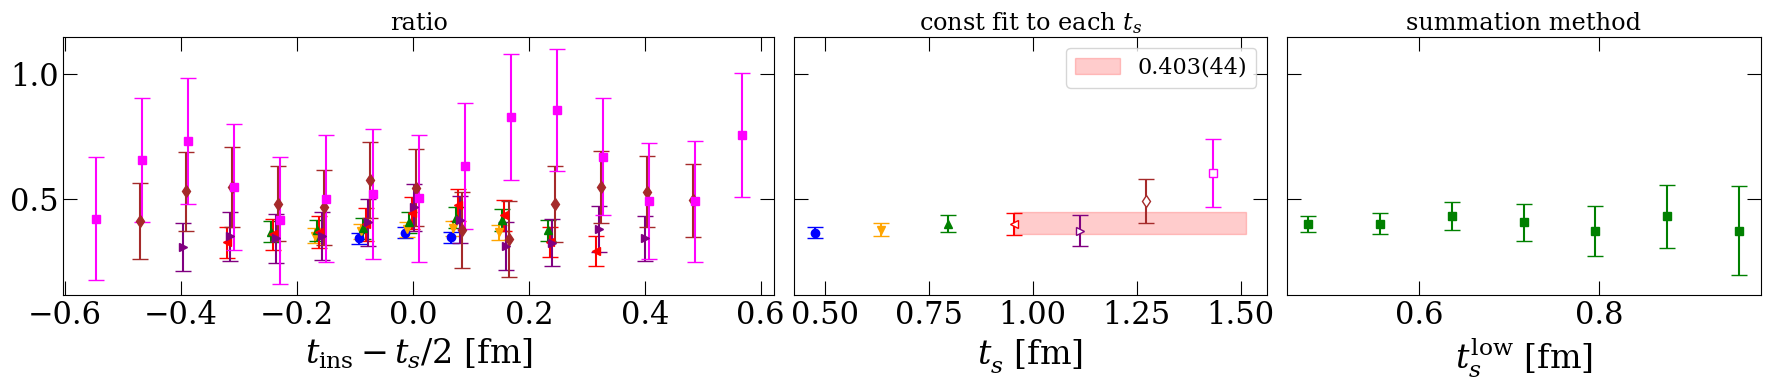

In [ ]:
selections=['bandfit_WA']
selection2key2bare={selection:key2bare_conn.copy() for selection in selections}

overwrite=True
def createDic(key):
    ens,j=key
    gett=lambda t:round(t/yu.ens2a[ens])
    def get_tfs(tmin,tmax,dt=1):
        return range(gett(tmin),gett(tmax),dt)
    lat_a=yu.ens2a[ens]
    
    # tfmins_1st=get_tfs(0.8,1.2)
    tcmins_1st=[gett(0.2)]
    tfmins_2st=get_tfs(0.5,0.8)
    tcmins_2st=[gett(0.2)]
    
    tf2ratio=yu.cut_tf2ratio(key2tf2ratio[(ens,j)],gett(1.5))
    fits_band=yu.doFit_3pt_band(tf2ratio,tcmins_1st,corrQ=False,label=f'{ens}_{j}_fits_band',overwrite=overwrite)
    fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.8),tf_max=gett(1.1),tcmin=max(gett(0.2),2),corrQ=False)
    # fits_const=yu.doFit_3pt_1st(tf2ratio,tfmins_1st,tcmins_1st,symmetrizeQ=True,label=f'{ens}_{j}_fits_const',overwrite=overwrite)
    # fit_const_MA=yu.doMA_3pt(fits_const,tcmin_min=3)
    fits_sum=yu.doFit_3pt_sum(tf2ratio,tfmins_2st,tcmins_2st,label=f'{ens}_{j}_fits_sum',overwrite=overwrite)
    # fit_sum_MA=yu.doMA_3pt(fits_sum,tcmin_min=3)
    # fits_2st=yu.doFit_3ptSym_2st2step(tf2ratio,tfmins_2st,tcmins_2st,pars_jk_meff2st=ens2pars_jk_meff2st[ens],symmetrizeQ=True,label=f'{ens}_{j}_fits_2st')
    # fit_2st_MA=yu.doMA_3pt(fits_2st,tcmin_min=2)
    
    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,fits_band,None,fits_sum,None],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[gett(0.5),gett(1.1),2,1],
        'fit_band:[tfmin,tfmax,tcmin_min,tcmin_max]':[gett(0.5),gett(1.1),gett(0.2),gett(0.2)],
        'fit_band_WA':fit_band_WA,
        # 'fit_const:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        # 'fit_const_MA':fit_const_MA,
        'fit_sum:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,gett(0.2),gett(0.2)],
        # 'fit_sum_MA':fit_sum_MA,
        # 'fit_2st:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        # 'fit_2st_MA':fit_2st_MA,
        'xunit':yu.ens2a[ens],
    }
    return dic

def createDic2(key):
    ens,j=key
    gett=lambda t:round(t/yu.ens2a[ens])
    def get_tfs(tmin,tmax,dt=1):
        return range(gett(tmin),gett(tmax),dt)
    lat_a=yu.ens2a[ens]
    
    # tfmins_1st=get_tfs(0.8,1.2)
    tcmins_1st=[gett(0.2)]
    tfmins_2st=get_tfs(0.4,1.0)
    tcmins_2st=[gett(0.2)]
    
    tf2ratio=yu.cut_tf2ratio(key2tf2ratio[(ens,j)],gett(1.5))
    fits_band=yu.doFit_3pt_band(tf2ratio,tcmins_1st,corrQ=False,label=f'{ens}_{j}_fits_band',overwrite=overwrite)
    fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.95),tf_max=gett(1.5),tcmin=max(gett(0.2),2),corrQ=False)
    # fits_const=yu.doFit_3pt_1st(tf2ratio,tfmins_1st,tcmins_1st,symmetrizeQ=True,label=f'{ens}_{j}_fits_const',overwrite=overwrite)
    # fit_const_MA=yu.doMA_3pt(fits_const,tcmin_min=3)
    fits_sum=yu.doFit_3pt_sum(tf2ratio,tfmins_2st,tcmins_2st,label=f'{ens}_{j}_fits_sum',overwrite=overwrite)
    # fit_sum_MA=yu.doMA_3pt(fits_sum,tcmin_min=3)
    # fits_2st=yu.doFit_3ptSym_2st2step(tf2ratio,tfmins_2st,tcmins_2st,pars_jk_meff2st=ens2pars_jk_meff2st[ens],symmetrizeQ=True,label=f'{ens}_{j}_fits_2st')
    # fit_2st_MA=yu.doMA_3pt(fits_2st,tcmin_min=2)
    
    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,fits_band,None,fits_sum,None],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[gett(0.5),gett(1.5),2,2],
        'fit_band:[tfmin,tfmax,tcmin_min,tcmin_max]':[gett(0.5),gett(1.5),gett(0.2),gett(0.2)],
        'fit_band:[dt]':[2],
        'fit_band_WA':fit_band_WA,
        # 'fit_const:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        # 'fit_const_MA':fit_const_MA,
        'fit_sum:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,gett(0.2),gett(0.2)],
        # 'fit_sum_MA':fit_sum_MA,
        # 'fit_2st:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        # 'fit_2st_MA':fit_2st_MA,
        'xunit':yu.ens2a[ens],
    }
    return dic


keys=[('b','jg;stout10')]
list_dic=[createDic2(key) if key[1].startswith('jg') else createDic(key) for key in keys]

colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']+['darkblue','darkgreen','darkred','grey']
yu.makePlot_3pt(list_dic,shows=['rainbow','fit_band','fit_sum'],colors_rainbow=colors,colors_fit=['g'])
yu.finalizePlot()

In [ ]:
# backup 
overwrite=False
def createDic(key):
    ens,j=key
    gett=lambda t:yu.find_t_cloest(t,ens)
    lat_a=yu.ens2a[ens]
    
    tfmins_1st=yu.get_tfs(0.8,1.2,ens)
    tcmins_1st=yu.get_tfs(2*lat_a,0.5,ens)
    tfmins_2st=yu.get_tfs(0.5,0.8,ens)
    tcmins_2st=yu.get_tfs(2*lat_a,0.5,ens)
    
    tf2ratio=yu.cut_tf2ratio(key2tf2ratio[(ens,j)],gett(1.5))
    fits_band=yu.doFit_3pt_band(tf2ratio,tcmins_1st,corrQ=False,label=f'{ens}_{j}_fits_band',overwrite=overwrite)
    fit_band_WA=yu.doWA_band(fits_band,tf_min=gett(0.8),tf_max=gett(1.3),tcmin=max(gett(0.2),2),corrQ=False)
    fits_const=yu.doFit_3pt_1st(tf2ratio,tfmins_1st,tcmins_1st,symmetrizeQ=True,label=f'{ens}_{j}_fits_const',overwrite=overwrite)
    fit_const_MA=yu.doMA_3pt(fits_const,tcmin_min=3)
    fits_sum=yu.doFit_3pt_sum(tf2ratio,tfmins_2st,tcmins_2st,label=f'{ens}_{j}_fits_sum',overwrite=overwrite)
    fit_sum_MA=yu.doMA_3pt(fits_sum,tcmin_min=3)
    # fits_2st=yu.doFit_3ptSym_2st2step(tf2ratio,tfmins_2st,tcmins_2st,pars_jk_meff2st=ens2pars_jk_meff2st[ens],symmetrizeQ=True,label=f'{ens}_{j}_fits_2st')
    # fit_2st_MA=yu.doMA_3pt(fits_2st,tcmin_min=2)
    
    dic={
        'base:[tf2ratio,fits_band,fits_const,fits_sum,fits_2st]':[tf2ratio,fits_band,fits_const,fits_sum,None],
        'rainbow:[tfmin,tfmax,tcmin,dt]':[None,gett(1.2),2,2],
        'fit_band:[tfmin,tfmax,tcmin_min,tcmin_max]':[gett(0.5),gett(1.3),None,None],
        'fit_band_WA':fit_band_WA,
        'fit_const:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'fit_const_MA':fit_const_MA,
        'fit_sum:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        'fit_sum_MA':fit_sum_MA,
        # 'fit_2st:[tfmin_min,tfmin_max,tcmin_min,tcmin_max]':[None,None,None,None],
        # 'fit_2st_MA':fit_2st_MA,
        'xunit':yu.ens2a[ens],
    }
    return dic

keys=[('b','j+;disc')]
list_dic=[createDic(key) for key in keys]

yu.makePlot_3pt_KyliakosStyle(list_dic)
yu.finalizePlot()

AttributeError: module 'util' has no attribute 'makePlot_3pt_KyliakosStyle'

In [346]:
js_plt=['j+;disc']; enss_plt=['b']
js_plt=js; enss_plt=enss

selections=['bandfit_WA','sum_first','sum_MA','const_MA']
selection2key2bare={selection:key2bare_conn.copy() for selection in selections}

for j in js_plt:
    keys=[(ens,j) for ens in enss_plt]

    list_dic=[{'tf2ratio':key2tf2ratio[(ens,j)],
            'tfs_rainbow':yu.get_tfs(0.5,1.2,ens),
            'tfs_bandfit':yu.get_tfs(0.5,1.2,ens),
            'tfs_sum':yu.get_tfs(0.5,1.2,ens),
            'tfmins_sum':yu.get_tfs(0.5,0.8,ens),
            'tfs_WA':yu.get_tfs(0.8,1.2,ens),
            'tcmin_rainbow':2,
            'tcmin_fit':yu.find_t_cloest(0.2,ens),
            'tfmins_const':yu.get_tfs(0.8,1.2,ens),
            'tcmins_const':yu.get_tfs(0.2,0.45,ens),
            'xunit':yu.ens2a[ens],
            } if 'jg' not in j else
            {'tf2ratio':key2tf2ratio[(ens,j)],
            'tfs_rainbow':yu.get_tfs(0.5,1.5,ens,2),
            'tfs_bandfit':yu.get_tfs(0.5,1.5,ens,2),
            'tfs_sum':yu.get_tfs(0.5,1.5,ens),
            'tfmins_sum':yu.get_tfs(0.4,1.0,ens),
            'tfs_WA':yu.get_tfs(0.95,1.5,ens),
            'tcmin_rainbow':2,
            'tcmin_fit':yu.find_t_cloest(0.2,ens),
            'tfmins_const':yu.get_tfs(0.95,1.5,ens),
            'tcmins_const':yu.get_tfs(0.2,0.45,ens),
            'xunit':yu.ens2a[ens],
            }
              for ens,j in keys]

    fig,axs,result=yu.makePlot_3pt_KyliakosStyle_extend(list_dic)
    for i,key in enumerate(keys):
        ens,j=key
        axs[i,0].set_ylabel(f'{yu.ens2label[ens]}')
    fig.suptitle(j)
    yu.finalizePlot(j)

    for selection in selections:
        for i,key in enumerate(keys):
            selection2key2bare[selection][key]=result[i][selection]

In [347]:
# RCs

ens2Njk={ens:len(ens2c2pt[ens]) for ens in enss}

path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs_me=pickle.load(f)
ens2RCs={ens:{} for ens in enss}
for ens in enss:
    for key in ens2RCs_me[ens]:
        if key.endswith('err'):
            continue
        ens2RCs[ens][key]=yu.jackknife_pseudo(ens2RCs_me[ens][key],ens2RCs_me[ens][f'{key}_err']+1e-10,ens2Njk[ens])[:,0]
        
path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/RCs_pre.pkl'
with open(path,'rb') as f:
    ens2RCs_pre_me=pickle.load(f)
ens2RCs_pre={ens:{} for ens in enss[:1]}
for ens in enss[:1]:
    for key in ens2RCs_pre_me[ens]:
        if key.endswith('err'):
            continue
        ens2RCs_pre[ens][key]=yu.jackknife_pseudo(ens2RCs_pre_me[ens][key],ens2RCs_pre_me[ens][f'{key}_err']+1e-10,ens2Njk[ens])[:,0]

In [348]:
selection2key2phy={}
selection2key2phy_pre={}
for selection in selections:
    key2bare=selection2key2bare[selection]
    yu.extendBare_avgx(key2bare)
    key2phy=yu.bareRC2phy_avgx(key2bare,ens2RCs)
    key2phy_pre=yu.bareRC2phy_avgx_pre(key2bare,ens2RCs,ens2RCs_pre)
    
    selection2key2phy[selection]=key2phy
    selection2key2phy_pre[selection]=key2phy_pre

In [349]:
figs=[]
stouts=[5,7,10,15,20]
for stout in stouts:
    list_dic=[
        {'key2phy':yu.convert_key2phy_stout(selection2key2phy[selection],stout),
        'key2phy_pre':yu.convert_key2phy_stout(selection2key2phy_pre[selection],stout)}
        for selection in selections
    ]
    fig,axs=yu.makePlot_a2dependence_avgx(list_dic)
    yu.addColHeader(axs,selections)
    fig.suptitle(f'stout{stout}')
    yu.finalizePlot(closeQ=True)
    figs.append(fig)
    
yu.makePDF('a2dep',figs)